In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

GPU available


# GPs with cellij
from: https://pyro.ai/examples/gp.html

In [2]:
import torch
import gpytorch
import pyro
import pandas as pd
import numpy as np
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns

import cellij

pyro.set_rng_seed(0)

/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is curre

,n_cells,label,division,division_scaled
obs0_1,1,None,0,0.0
obs1_1,1,None,0,0.0
obs2_1,1,None,0,0.0
obs3_1,1,None,0,0.0
obs4_1,1,None,0,0.0
...,...,...,...,...
obs432_64_TE,64,TE,6,1.0
obs433_64_TE,64,TE,6,1.0
obs434_64_TE,64,TE,6,1.0
obs435_64_TE,64,TE,6,1.0


In [19]:
d = "guo"

if d == "guo":
    imp = cellij.core.Importer()
    mdata = imp.load_Guo2010()
    adata = mdata["qPCR"]
    X = torch.tensor(adata.to_df().values).float()
    time = torch.tensor(mdata.obs["division_scaled"]).float()
elif d == "mefisto":
    imp = cellij.core.Importer()
    mdata = imp.load_MEFISTO()
    adata = mdata["view1"]
    X = torch.tensor(adata.to_df().values).float()
    time = torch.tensor(np.linspace(0, 1, data.shape[0])).float()

X.shape

/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:577: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:577: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


torch.Size([437, 48])

In [4]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, n_factors, init_lengthscale=5.,): 
        n_inducing = len(inducing_points)
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=n_inducing, batch_shape = torch.Size([n_factors]),
            )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            model=self, 
            inducing_points=torch.tensor(
                data=inducing_points,
                dtype=torch.float32
            ), 
            variational_distribution=variational_distribution, 
            learn_inducing_locations=False,
        )

        super().__init__(variational_strategy=variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean(
            batch_shape=torch.Size([n_factors]),
            )
        self.kernel = gpytorch.kernels.RBFKernel(batch_shape = torch.Size([n_factors]))
        self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
        self.covar_module.base_kernel.lengthscale = init_lengthscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:


class MEFISTO(gpytorch.Module):
    def __init__(
        self,
        data,
        time,
        n_factors,
        device,
    ):
        super().__init__()
        pyro.clear_param_store()

        self.device = device
        self.n_factors = n_factors
        self.data = data
        self.time = time # .to(device=self.device).detach()
        self.n_obs = self.data.shape[0]
        self.n_features = self.data.shape[1]
        print(self.n_features, self.n_obs)
        self.unique_time = self.time.unique()
        # self.unique_time = torch.linspace(
        #     self.time.min(), 
        #     self.time.max(), 
        #     int(self.n_obs/10),
        #     device=self.device
        # ).float()
        self.to(device)
        
        self.plates = {
            "obs": pyro.plate("obs", self.n_obs, dim=-1, device=self.device),
            "factors": pyro.plate("factors", n_factors, dim=-2, device=self.device),
            "features": pyro.plate("features", self.n_features, dim=-3, device=self.device),
        }
        
        self.gp = GPModel(
            inducing_points=self.unique_time,
            n_factors=self.n_factors
        ).to(device=self.device)

                # self.w_init = _init_pca(self.time, 0) # Initialise X to PCA
        
    def model(self):
        pyro.module("gp", self)
        
        with self.plates["features"], self.plates["factors"]:
            w = pyro.sample(
                "w", 
                dist.Normal(
                    torch.tensor(0.0, device=self.device), 
                    torch.tensor(1.0, device=self.device)
                )
            ).to(self.device).view(-1, self.n_features, self.n_factors, 1)

        with self.plates["factors"], self.plates["obs"]:
            z = pyro.sample(
                    "z",
                    self.gp.pyro_model(self.time),
                ).to(self.device).view(-1, 1, self.n_factors, self.n_obs)
        
        prod = torch.matmul(
            input=w.squeeze(),
            other=z.squeeze(),
        ).to(self.device).view(-1, self.n_features, 1, self.n_obs)

        with self.plates["features"], self.plates["obs"]:
            pyro.sample(
                name='obs',
                fn=dist.Normal(prod, 1.),
                obs=self.data.T.view(-1, self.n_features, 1, self.n_obs),
            ).to(self.device)

    def guide(self):
        w_loc = pyro.param('w_loc',  init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=0.0,
                dtype=torch.float32,
                device=self.device,
            )).view(-1, self.n_features, self.n_factors, 1)
        w_scale = pyro.param('w_scale', init_tensor=torch.full(
                size=[self.n_features, self.n_factors],
                fill_value=1.0,
                dtype=torch.float32,
                device=self.device,
            )).view(-1, self.n_features, self.n_factors, 1)
        
        with self.plates["features"], self.plates["factors"]:
            pyro.sample(
                "w", 
                dist.Normal(w_loc, w_scale)
            ).to(self.device).view(-1, self.n_features, self.n_factors, 1)
        
        with self.plates["factors"], self.plates["obs"]:
            pyro.sample(
                    "z",
                    self.gp.pyro_guide(self.time),
            ).to(self.device).view(-1, 1, self.n_factors, self.n_obs)

    def inference(self, num_particles=15, max_epochs=1000):
        self.optimizer = pyro.optim.Adam({"lr": 1e-3})

        elbo = pyro.infer.Trace_ELBO(
            retain_graph=True,
            num_particles=num_particles,
            vectorize_particles=True,
        )

        svi = pyro.infer.SVI(
            model=self.model,
            guide=self.guide,
            optim=self.optimizer,
            loss=elbo,
        )

        self.train()
        self.losses = []
        for epoch in range(max_epochs):
            self.zero_grad()
            loss = svi.step()
            self.losses.append(loss)
            if epoch % 100 == 0:
                print(epoch, loss)
                
    def get_factors(
        self,
        n_samples: int=25,
        ) -> torch.tensor:
        """Get the inferred means of the factors.
        
        Args:
            n_samples: number of samples to use for mean estimate

        Returns:
            tensor of shape (n_cells, n_factors, res, res)
        """
        self.eval()
        
        factor_means = []
        with torch.no_grad():
            dist = self.gp(self.unique_time)
            samples = dist(torch.Size([n_samples])).cpu()
            mean = samples.mean(dim=0)
            mean = torch.transpose(mean, -1, -2)
            factor_means.append(torch.transpose(mean, -1, -2))

        factor_means = torch.stack(factor_means, dim=0)

        self.train()

        return factor_means

print(f"{X.shape=}")
print(f"{time.shape=}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MEFISTO(data=X, time=time, n_factors=4, device=device)

X.shape=torch.Size([437, 48])
time.shape=torch.Size([437])
48 437


/tmp/ipykernel_1640140/214542631.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducing_points=torch.tensor(


In [6]:
model.inference(num_particles=10, max_epochs=10000)

0 60318.54375
100 47419.372729492185
200 41766.31357421875
300 38393.84458007813
400 36874.32019042969
500 35412.45244140625
600 34612.41831054688
700 34228.34604492188
800 33730.40455322266
900 33428.350415039065
1000 32874.173120117186
1100 32634.548095703125
1200 32282.73826904297
1300 32074.54442138672
1400 31815.107043457032
1500 31535.086846923827
1600 31310.316821289063
1700 31115.66339111328
1800 30897.82707824707
1900 30751.258499145508
2000 30592.464599609375
2100 30488.880822753905
2200 30410.524768066407
2300 30359.87550048828
2400 30322.14462890625
2500 30294.030187988283
2600 30281.651928710937
2700 30277.24317626953
2800 30280.154663085938
2900 30271.74443359375
3000 30260.150354003905
3100 30252.08056640625
3200 30261.82468261719
3300 30255.899829101563
3400 30261.694409179687
3500 30253.082788085936
3600 30252.465441894532
3700 30251.88211669922
3800 30255.87236328125
3900 30262.991284179687
4000 30255.23405761719
4100 30251.053088378907
4200 30258.98664550781
4300 302

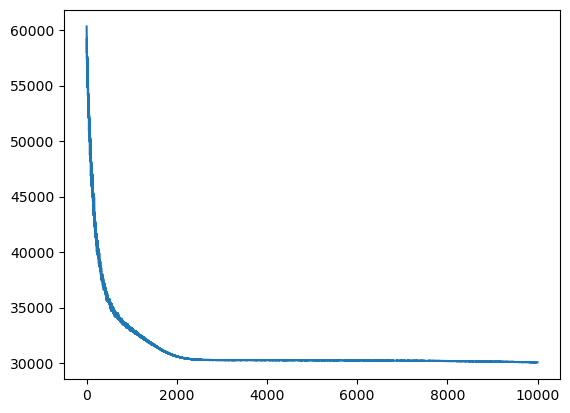

In [7]:
plt.plot(model.losses)

In [8]:
d = model.get_factors(n_samples=1000000)
print(d.shape)

torch.Size([1, 4, 7])


In [10]:
factor_means = []
with torch.no_grad():
    dist = model.gp(time)
    samples = dist(torch.Size([10000])).cpu()
    mean = samples.mean(dim=0)
    mean = torch.transpose(mean, -1, -2)
    factor_means.append(torch.transpose(mean, -1, -2))

factor_means = torch.stack(factor_means, dim=0)
factor_means

tensor([[[-8.6588e-04, -7.7281e-04, -7.9761e-04,  ..., -2.4512e-04,
          -3.5716e-05,  8.8458e-05],
         [ 1.4143e-03,  1.3965e-03,  1.4735e-03,  ...,  1.7151e-03,
           1.5961e-03,  1.4924e-03],
         [ 9.8072e-04,  1.1812e-03,  1.2136e-03,  ...,  1.8425e-03,
           1.9257e-03,  1.7384e-03],
         [ 2.4028e-03,  2.5041e-03,  2.4304e-03,  ...,  2.6793e-03,
           2.7352e-03,  2.7266e-03]]], device='cpu')

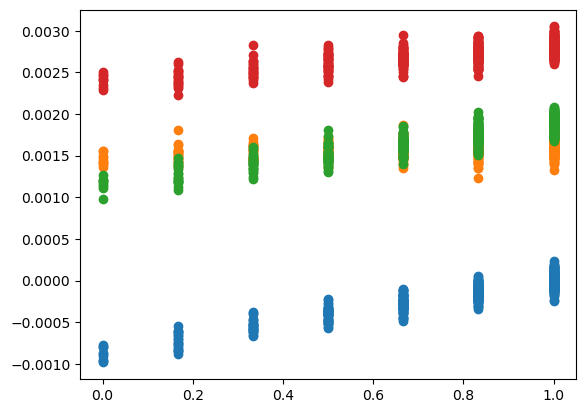

In [11]:
for i in range(4):
    plt.scatter(time.cpu().detach().numpy(), factor_means.squeeze()[i], )

In [12]:
sns.heatmap(data.cpu().detach(), cmap="seismic", center=0)

NameError: name 'data' is not defined

(4, 7)


<Axes: >

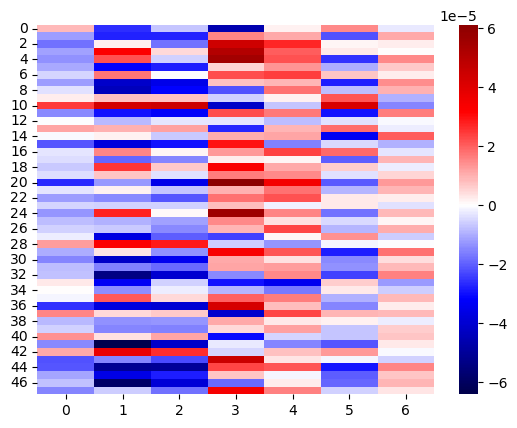

In [13]:
z = pyro.param('gp$$$gp.variational_strategy._variational_distribution.variational_mean').cpu().detach().numpy()
print(f"{z.shape}")
w = pyro.param("w_loc").squeeze().cpu().detach().numpy()
sns.heatmap(w@z, center=0, cmap="seismic")

In [ ]:
sns.heatmap(w, center=0, cmap="seismic")

In [25]:
import umap
y = w@z

# Create a UMAP object with desired parameters
umap_obj = umap.UMAP()

# Fit the UMAP model to your matrix
umap_result = umap_obj.fit_transform(factor_means.squeeze().T)


In [32]:
time.to_numpy()

AttributeError: 'Tensor' object has no attribute 'to_numpy'

/tmp/ipykernel_1640140/3049544779.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_labels)
/home/icb/tim.treis/miniconda3/envs/cellij/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


             0         1  time label
0    -0.864007  8.742358   0.0  None
1    -0.784551  8.608959   0.0  None
2    -0.691316  8.743274   0.0  None
3    -0.852942  8.794617   0.0  None
4    -0.835011  8.768870   0.0  None
..         ...       ...   ...   ...
432  11.391443  7.049124   1.0    TE
433  10.890139  7.076397   1.0    TE
434   7.241819  9.877713   1.0    TE
435  10.699041  9.503592   1.0    TE
436  10.432135  8.453794   1.0    TE

[437 rows x 4 columns]


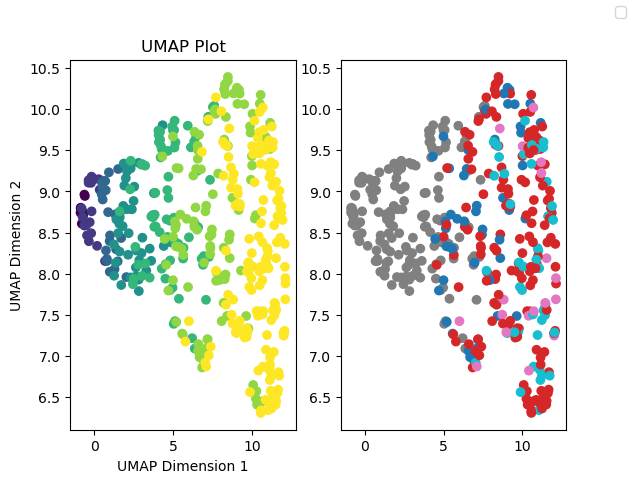

In [53]:
umap_result = pd.DataFrame(umap_result)
umap_result["time"] = mdata.obs["division_scaled"].values
umap_result["label"] = mdata.obs["label"].values
print(umap_result)

label_set = set(umap_result["label"]) - {None}
num_labels = len(label_set)
color_map = plt.cm.get_cmap('tab10', num_labels)
label_to_color = {label: color_map(i) for i, label in enumerate(label_set)}

# Assign colors to the points based on the labels
colors = [label_to_color[label] if label in label_to_color else 'gray' for label in umap_result["label"]]

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].scatter(umap_result[0], umap_result[1], c = umap_result["time"])
axs[0].set_xlabel('UMAP Dimension 1')
axs[0].set_ylabel('UMAP Dimension 2')
axs[0].set_title('UMAP Plot')

axs[1].scatter(umap_result[0], umap_result[1], c = colors)


In [ ]:
sns.heatmap(d.squeeze(), center=0, cmap="seismic")

In [ ]:
sns.heatmap(w.squeeze(), center=0, cmap="seismic")

In [ ]:
print(

np.array(d.T.squeeze())[:, 1] @  w[:, 1]

In [ ]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

test_x = torch.linspace(0, 1, 100).float()

model.eval()
with torch.no_grad():
    output = model.gp(test_x)

samples = output(torch.Size([1000]))
lower, mean, upper = percentiles_from_samples(samples)

In [ ]:
for k in range(2):
    # visualize the result
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    line, = ax.plot(test_x, mean[k].detach().cpu().numpy(), label='GP prediction')
    ax.fill_between(
        test_x, lower[k].detach().cpu().numpy(),
        upper[k].detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )

In [ ]:
plt.plot(